# Control of Aggregate Equilibrium Size

Reference https://ac-els-cdn-com.ezproxy.neu.edu/S092777571300558X/1-s2.0-S092777571300558X-main.pdf?_tid=a68d75de-2d4b-4e84-858f-c3866c0dcf14&acdnat=1542312142_f822cc2a074bc4ea24c4df9fcae90672 for the initial part of the project.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math

In [96]:
#set up the bins
L = np.linspace(0,20,101)
size_step = np.diff(L)

In [53]:
#the initial distribution is arbitrary
def initial(L):
    density = 0.4*np.exp(-(L-5)**2/5)
    return density

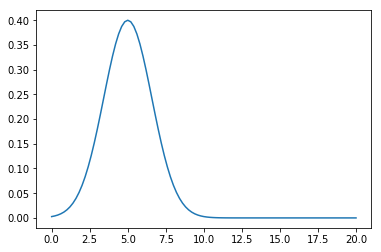

(1.5840900787422294, 2.771846964117317e-10)

In [54]:
plt.plot(L, initial(L))
plt.show()

#integral should be close to 1
integrate.quad(initial, 0, 20)

In [55]:
space_under_curve = integrate.quad(initial, 0, 20)[0]
for l in L:
    if (integrate.quad(initial, 0, l)[0] >= 0.5*space_under_curve):
        avg_size = l
        break
avg_size
#average size in um

5.2

**Assume there is no growth or brakage and only aggregation for now. (Eq. 2)**

$$\frac{\Delta n}{\Delta t} = B - D$$

**To calculate the aggregation frequency, use the following equation. (Eq. 3)**

$$\beta_{j,k} = \frac{2k_BT}{3{\mu}W_{j,k}}(r_j+r_k)(\frac{1}{r_j}+\frac{1}{r_k}) $$

Where the stability ratio $$ W_{j,k} = (r_j+r_k)\int_{r_j+r_k}^{\infty} \frac{exp(V_T/(k_bT))}{R^2} dR $$

$$ V_T = V_A + V_E $$

$$ V_A = -\frac{A}{6}(\frac{2r_1r_2}{R^2-(r_1+r_2)^2}+\frac{2r_1r_2}{R^2(r_1-r_2)^2}+\frac{R^2-(r_1+r_2)^2}{R^2-(r_1-r_2)^2}) $$

$$ V_E = 64\pi\epsilon_r\epsilon_0(\frac{k_BT}{z_ce})^2 tanh(\frac{z_ce\psi_{01}}{4k_BT})tanh(\frac{z_ce\psi_{02}}{4k_BT})(\frac{r_1r_2}{r_1+r_2})exp(-\kappa(R-r_1-r_2)) $$

The value of the debye-huckel parameter comes from Russel, W.B., Saville, D.A. and Schowalter, W. R. Colloidal Dispersions, Cambridge University Press, 1989


$$ \kappa = \sqrt{\frac{2000e^2N I}{\epsilon_r \epsilon_0 k T}} $$

Where the ionic strength is the weighted sum of valence of the ions in solution. $$ I = \frac{1}{2}\sum_j m_j z_j^2 $$

But this should simplify because we only have one ion in solution and we can solve for the molality and we already have the valence of the counterion.

In [56]:
#some constants, from paper
kB = 1.3806 * 10**(-23) #m^2 * kg / (s^2 * K)
A = 3.08 * 10**(-20) #J
psi = 59./1000 #mV #surface potential (UNITS???)
T = 300. #K, im assuming this cuz its not given
mu = 0.00086 #N * s / m^2, from engineering toolbox cuz its not given
er = 80.4 #dielectric constant of solvent (water)
e0 = 8.85*10**-12 #dielectric constant of vacuum (F/m) eng'g toolbox
zc = 1. #valence of potassium counterion
e = 1.6021766*10**-19 # elementary charge (C)
N = 6.022*10**23 #Avogadros Number
rho = 1.*10**3 #kg/m^3 

In [57]:
#solve for the Debye-Huckel Parameter
#it depends on the molality of salt ions in solution

#ONLY VALID AT 0.29 M SALT

M = 0.29 #mol/L
m = M*1000/(rho)
I = (m*zc**2)/2
#kappa = (8*(math.pi**2)*N*rho*I/(1000*er*kB*T))**.5 old value, gave value on order of 10^20
kappa = (er * e0 * kB * T / (2 * 1000 * N *e**2 * I))**0.5
print("The value for the Debye-Huckel Parameter is {}".format(kappa))
#debye huckel only value for low concentration electrolytes, which this isnt

The value for the Debye-Huckel Parameter is 8.108013489212379e-10


In [58]:
#attractive potential
def Va(R, r1, r2):
    Va =-A/6*(2*r1*r2/(R**2-(r1+r2)**2)+2*r1*r2/(R**2*(r1-r2)**2)+(R**2-(r1 + r2)**2)/(R**2-(r1-r2)**2))
    return Va

#repulsive potential
def Ve(R, r1,r2):
    Ve=64*math.pi*er*e0*(kB*T/(zc*e))**2*(np.tanh(zc*e*psi/(4. * kB * T)))**2*r1*r2/(r1+r2)*np.exp(-kappa*(R-r1-r2))
    return Ve

#total potential
def VT(R, r1,r2):
    VT = Ve(R) +Va(R)
    return VT

#integrand to solve for the stability ratio
def W(R, r1,r2):
    W = (r1+r2) * np.exp(VT(R)/(kB*T))/(R**2)
    return W

# Brownian Type Aggregation Kernel

In [59]:
#aggregation frequency / growth kernel
#takes in r1 and r2 and outputs aggregation frequency
def Beta(r1, r2):
    #eqn 3 (Brownian aggregation), 4 (aggregation efficiency),
    # and 5 and 6 (interaction potential components)
    # the equations use both j,k and 1,2 should we just use one consistently?
    r1=r1 /10**6
    r2=r2 / 10**6
    if(r1==0):
        r1 = 0.00001
    if(r2==0):
        r2 = 0.00001
    
    #center-to-center distance when the particles are in contact
    R0 = r1+r2
    
    #solve for the stability ratio
    #we have to integrate over the range in possible center-to-center distances
    
    #assume all collisons result in aggregation
    #Wjk = integrate.quad(W, R0, 1000.)
    Wjk = 0.00000000001
    
    # in eqn theres two tanh for the two colliding paticles but if theyre the same they have the same surface potential
    #solve for the aggregation frequency
    #calculate the combinations of two particles that can lead to an aggregate of size R0
 
    beta = 2 * kB * T / (3 * mu * Wjk) * (r1 + r2) * (1/r1 + 1/r2)
    return beta

In [60]:
Beta(0.7,1.3)

1.411295681063123e-06

# Birthrate and Deathrate

In [61]:
#all possible combinations
beta_matrix = np.zeros((len(L),len(L)))
for indexi, i in enumerate(L):
    for indexj, j in enumerate(L):
        if(j < i):
            beta_matrix[indexi,indexj] = Beta(i,j)
        else:
            break
print(beta_matrix.shape)
#beta_matrix

(101, 101)


In [105]:
#birth rate
n = initial(L)

#takes in a particle size and a distribution
def birthrate(particle_size, n):
    for i in enumerate(L):
        size = i[1]
        if (size==particle_size):
            indexL = i[0]
            break
            
    subL = L[1:indexL:1]
    
    birth = 0
    indexi = 0
    volume 
    for i in subL:
        indexj = 0
        for j in subL:
            if (i**3+j**3 <= L[indexL]**3 and i**3+j**3 > L[indexL-1]**3):
                birth += Beta(i,j)*n[indexi]*n[indexj]
            indexj += 1
        indexi += 1
        
    return birth

In [109]:
print(birthrate(4, n))

4.722517461012547e-07


In [110]:
#death rate
def deathrate(particle_size, n):
    for i in enumerate(L):
        size = i[1]
        if (size==particle_size):
            indexj = i[0]
            break
            
    j = particle_size
    death = 0
    indexi = 0
    for i in L:
        death += Beta(i,j)*n[indexi]*n[indexj]
        indexi += 1
        
    return death

In [111]:
print(deathrate(4, n))

3.483900969919321e-06


# Calculate the Rate of Change

In [130]:
#solve different equation for each bin in L
#ref in class example for first order finite difference
def rates_of_change(n, t, L, end_time=0):
    size_step = np.diff(L)
    
    #rates of transition
    rates_of_transition = np.zeros_like(n)
    for i in range(len(rates_of_transition)):
        rates_of_transition[i] = n[i] * (birthrate(L[i],n) - deathrate(L[i],n))/size_step[0]
        
    #conservation of particle mass, in this case volume with constant density
        
    #monitor ode solver
    print("running at time {}/{} seconds...".format(t,end_time))
    
    return rates_of_transition

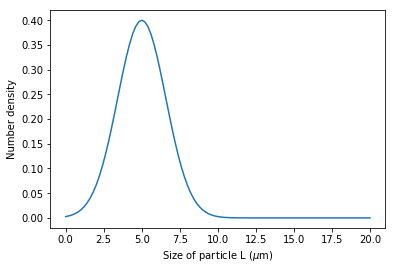

running at time 0/0 seconds...


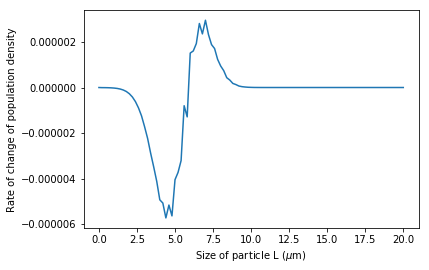

In [131]:
#at time zero what does it look like?
n = initial(L)
t= 0
plt.plot(L, initial(L))
plt.ylabel('Number density')
plt.xlabel('Size of particle L ($\mu$m)')
plt.show()

plt.plot(L,rates_of_change(n, t, L))
plt.ylabel('Rate of change of population density')
plt.xlabel('Size of particle L ($\mu$m)')
plt.show()

# Solve Set of Diff Eqs

In [132]:
times = np.arange(0,2000,1000)
times

array([   0, 1000])

In [133]:
%%timeit -n1 -r1
results = integrate.odeint(rates_of_change, initial(L), times, args=(L,times[-1]), max)

running at time 0.0/1000 seconds...
running at time 0.12206940828542635/1000 seconds...
running at time 0.12206940828542635/1000 seconds...
running at time 0.2441388165708527/1000 seconds...
running at time 0.2441388165708527/1000 seconds...
running at time 200.31725620274287/1000 seconds...
running at time 200.31725620274287/1000 seconds...
running at time 400.3903735889149/1000 seconds...
running at time 400.3903735889149/1000 seconds...
running at time 600.4634909750869/1000 seconds...
running at time 600.4634909750869/1000 seconds...
running at time 1228.0125706848178/1000 seconds...
running at time 1228.0125706848178/1000 seconds...
28.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [134]:
integrate.odeint?

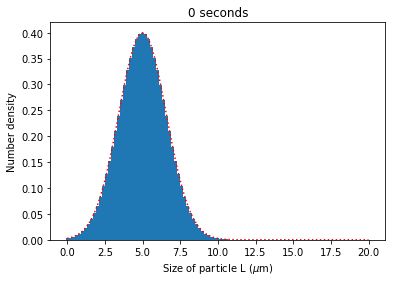

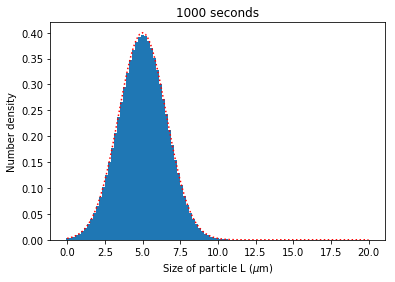

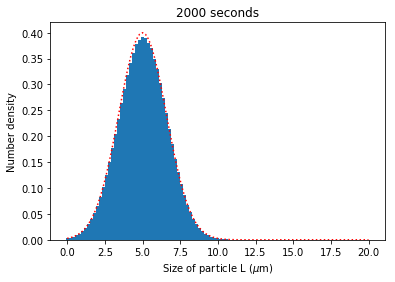

In [122]:
size_step = np.diff(L)
for time, result in zip(times, results):
    plt.plot(L, initial(L), 'r:')
    plt.bar(L, result, width=size_step[0])
    plt.title("{} seconds".format(time))
    plt.ylabel('Number density')
    plt.xlabel('Size of particle L ($\mu$m)')
    plt.show()